In [1]:
import torch
import scvi
import scanpy as sc
import os
import tempfile

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

## scVI Integration
For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information.

In [3]:
adata = sc.read_h5ad('adata.h5ad')

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate using all genes in terms of runtime, we usually recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the adata.raw object. We obtain variable genes from each dataset and take their intersections.

In [13]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    batch_key="project",
    subset=True,
    layer='counts',
    span = 0.9
)

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample and the layer key with the count data.

- Create an SCVI model object.

In [15]:
scvi.model.SCVI.setup_anndata(adata, batch_key="project",layer = 'counts')
#These parameters generally work in integration
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
#Train model, could take ~10 minutes
model.train()

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|██████████| 400/400 [06:06<00:00,  1.09it/s, loss=1.56e+03, v_num=1]


In [16]:
#get latent variable space within scVI model
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
# get neighborhood structure using scVI 
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata) #leiden cluster
sc.tl.umap(adata) #run umap

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

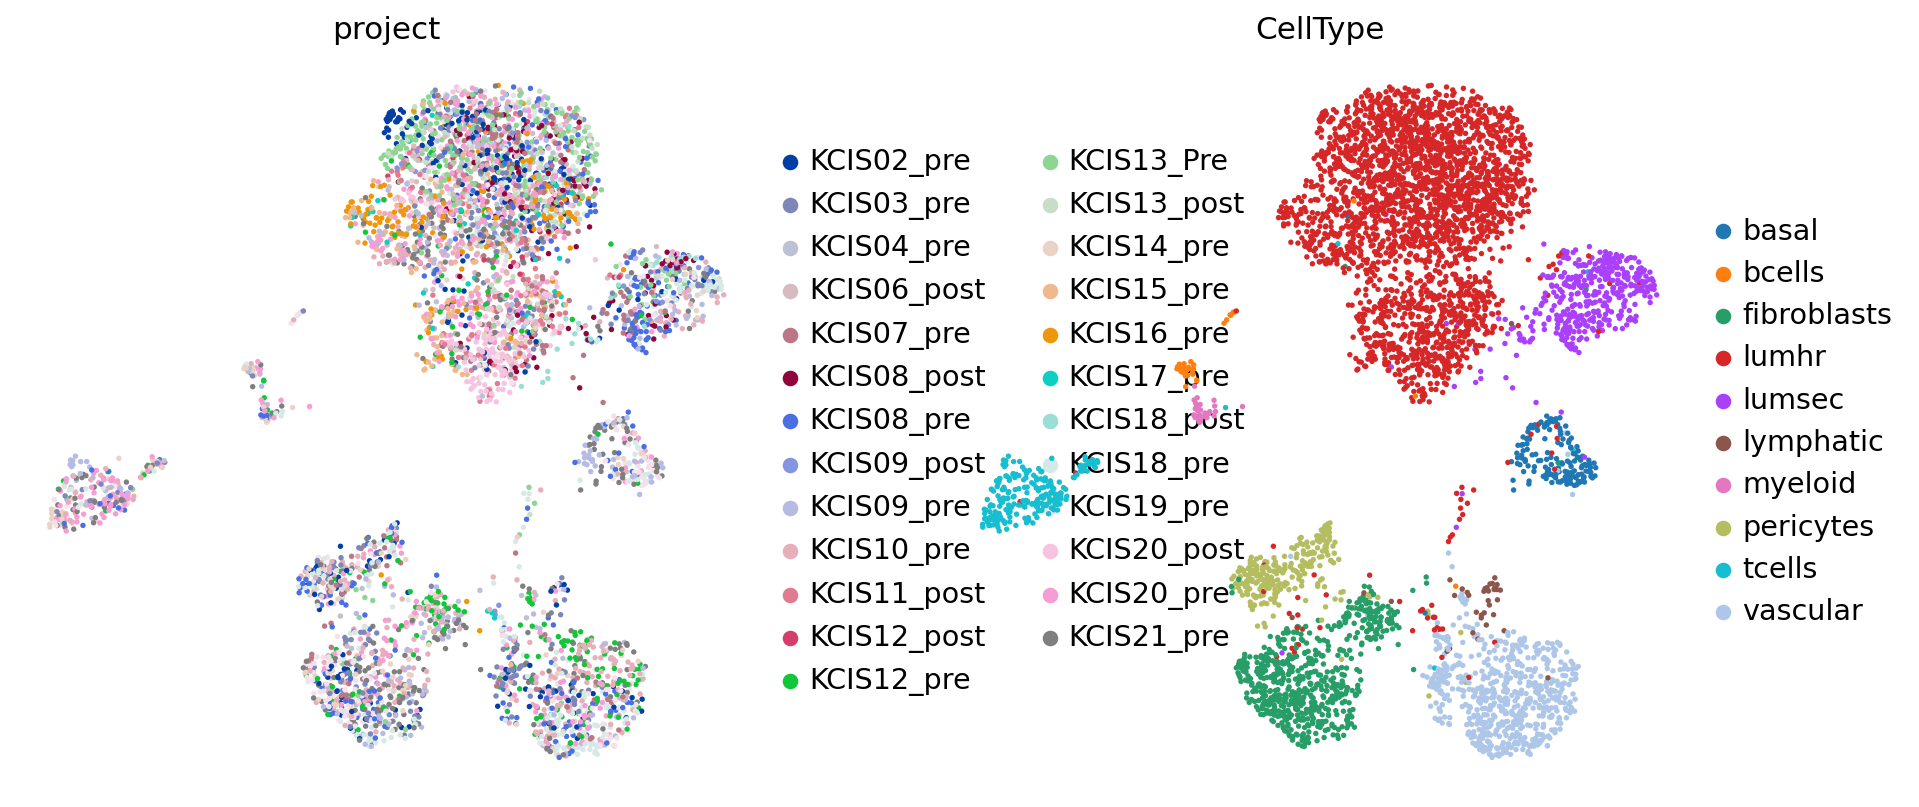

In [20]:
#plot umap projection
sc.pl.umap(adata,color = ['project','CellType'])

## Optional: Refine Embeddings with scANVI
Can be utilized where cell type information is present to improve scVI model

Now, we assume that all of our data is annotated. This can lead to a more accurate integration result when using scANVI

Since we’ve already trained an scVI model on our data, we will use it to initialize scANVI. When initializing scANVI, we provide it the labels_key. As scANVI can also be used for datasets with partially-observed annotations, we need to give it the name of the category that corresponds to unlabeled cells. As we have no unlabeled cells, we can give it any random name that is not the name of an exisiting cell type.

In [22]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="CellType",
    unlabeled_category="Unknown",
)
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/_scanvi.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels == self.unlabeled_category_
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scvi/model/_scanvi.py:255: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self._labeled_indices = np.argwhere(labels != self.unlabeled_category_).ravel()
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 20/20: 100%|██████████| 20/20 [00:19<00:00,  1.03it/s, loss=1.61e+03, v_num=1]


Again, we may visualize the latent space as well as the inferred labels

In [23]:

SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY])
sc.pp.neighbors(adata,use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bstrope/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

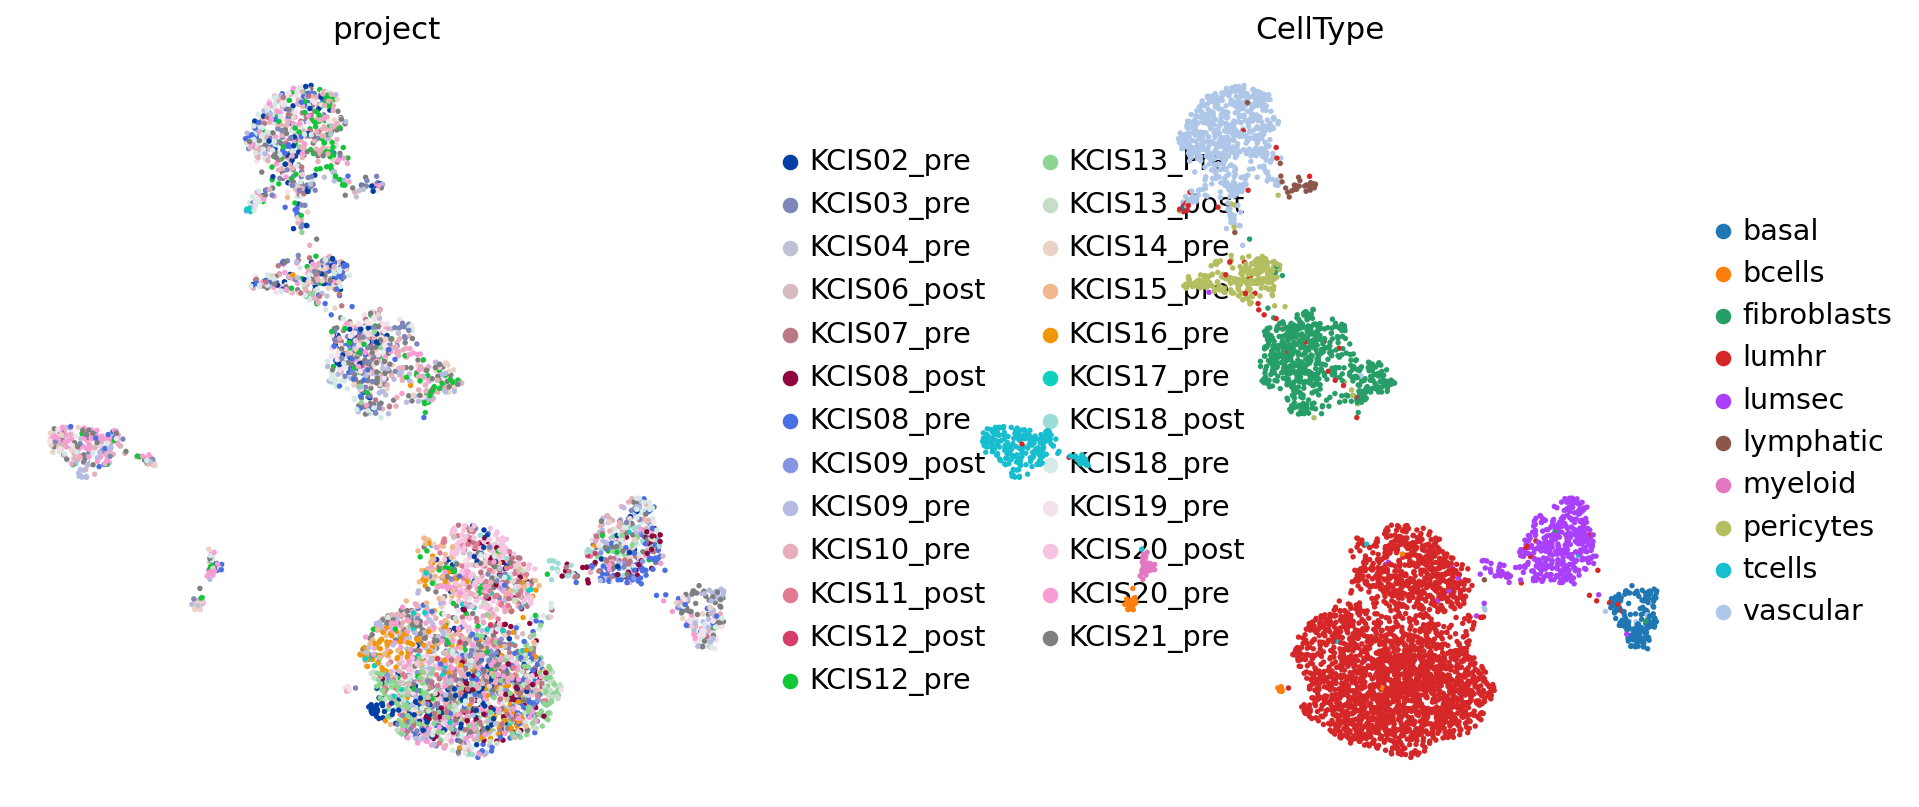

In [27]:
sc.pl.umap(adata,color = ['project','CellType'])